## Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [73]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, eigs
from scipy.linalg import svd
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

In [2]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('Electronic_dataset.csv',names=columns)

In [3]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,user_id,prod_id,ratings,timestamp
1,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
2,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
3,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
4,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400


In [4]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [5]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500001 entries, 0 to 500000
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     500001 non-null  object
 1   productId  500001 non-null  object
 2   ratings    500001 non-null  object
dtypes: object(3)
memory usage: 11.4+ MB


In [6]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  500001
Number of columns:  3


In [7]:
#Check the datatypes
electronics_df.dtypes

userId       object
productId    object
ratings      object
dtype: object

In [8]:
#Summary statistics of rating variable
electronics_df['ratings'].describe().transpose()

count     500001.0
unique        11.0
top            5.0
freq      204856.0
Name: ratings, dtype: float64

In [9]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Number of Each Rating')

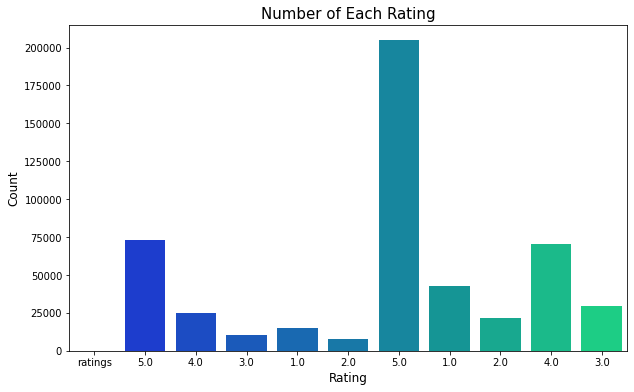

In [10]:
# Check the distribution of the rating
plt.figure(figsize=(10,6))
sns.countplot(x='ratings',data=electronics_df,palette='winter')
plt.xlabel('Rating',fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Each Rating', fontsize=15)
plt.show()

We can see that more number of users have given the rating of 5 

In [11]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df['productId'].nunique())

Number of unique users in Raw data =  448369
Number of unique product in Raw data =  130139


Taking the subset of dataset to make it less sparse/ denser

In [12]:
#Check the top 10 users based on ratings
most_rated=electronics_df.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A680RUE1FDO8B     36
A3OXHLG6DIBRW8    34
ADLVFFE4VBT8      30
A5JLAU2ARJ0BO     29
A2NOW4U7W3F7RI    28
A231WM2Z2JL0U3    24
A6FIAB28IS79      23
A2AY4YUOX2N1BQ    23
A4WEZJOIZIV4U     22
A1ODOGXEYECQQ8    21
dtype: int64


In [13]:
counts=electronics_df.userId.value_counts()
electronics_df_final=electronics_df[electronics_df.userId.isin(counts[counts>=10].index)]
print('Number of users who have rated 10 or more items =', len(electronics_df_final))
print('Number of unique users in the final data = ', electronics_df_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df_final['userId'].nunique())

Number of users who have rated 10 or more items = 1875
Number of unique users in the final data =  136
Number of unique products in the final data =  136


In [14]:
#constructing the pivot table
final_ratings_matrix = electronics_df_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IEFUB02,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,4.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A1143YEAZYMYHJ,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,5.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [15]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (136, 1723)


We can see that there are 136 products and 1723 users

In [16]:
#Calculating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  1875
possible_num_of_ratings =  234328
density: 0.80%


### **Splitting the data to Training and Test Data**

In [17]:

#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
79226,A38RMU1Y5TDP9,B00HTPHK5W,5.0
96981,A3REK3OFONWB1Q,B003Y2V09Q,5.0
431242,A4WEZJOIZIV4U,B007RE0EQC,5
259454,A2XRMQA6PJ5ZJ8,B002Y1U2M4,5
170260,A2XIOXRRYX0KZY,B00009UHET,4


In [18]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (1312, 3)
Shape of testing data:  (563, 3)


## **Building Popularity Recommder model**

In [19]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,B00000J1US,1
1,B00004R8VC,1
2,B00004SD9Q,1
3,B00004T8R2,1
4,B00004WCG6,1
5,B00004WCIC,1
6,B00004Y7TC,1
7,B00004Z4ZB,1
8,B00004Z6OK,1
9,B00004ZCA0,1


In [20]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
885,B0088CJT4U,6,1.0
331,B001E1Y5O6,4,2.0
231,B000RZQZM0,3,3.0
551,B003ES5ZSW,3,4.0
857,B007R5YDYA,3,5.0


In [21]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [22]:
find_recom = [48,129,254]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 48

     userId   productId  score  rank
885      48  B0088CJT4U      6   1.0
331      48  B001E1Y5O6      4   2.0
231      48  B000RZQZM0      3   3.0
551      48  B003ES5ZSW      3   4.0
857      48  B007R5YDYA      3   5.0


The list of recommendations for the userId: 129

     userId   productId  score  rank
885     129  B0088CJT4U      6   1.0
331     129  B001E1Y5O6      4   2.0
231     129  B000RZQZM0      3   3.0
551     129  B003ES5ZSW      3   4.0
857     129  B007R5YDYA      3   5.0


The list of recommendations for the userId: 254

     userId   productId  score  rank
885     254  B0088CJT4U      6   1.0
331     254  B001E1Y5O6      4   2.0
231     254  B000RZQZM0      3   3.0
551     254  B003ES5ZSW      3   4.0
857     254  B007R5YDYA      3   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

## **Building Collaborative Filtering recommender model.**

In [102]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,79226,A38RMU1Y5TDP9,B00HTPHK5W,5.0
1,96981,A3REK3OFONWB1Q,B003Y2V09Q,5.0
2,431242,A4WEZJOIZIV4U,B007RE0EQC,5
3,259454,A2XRMQA6PJ5ZJ8,B002Y1U2M4,5
4,170260,A2XIOXRRYX0KZY,B00009UHET,4


User Based Collaborative Filtering model

In [103]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IEFUB02,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,4.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A1143YEAZYMYHJ,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,5.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [104]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (136, 1723)


In [105]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.tail()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0,user_index
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVPNQUVZWMDSX,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,131
AWPODHOB4GFWL,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,132
AX05DBU8IRUWY,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,5.0,0.0,0.0,0.0,0,0,133
AY6A8KPYCE6B0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,134
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,5.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,135


In [106]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.tail()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IEFUB02,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
131,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
132,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
133,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,5.0,0.0,0.0,0.0,0,0
134,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
135,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,5.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


As this is a sparse matrix we will use SVD.

# **Singular Value Decomposition**

In [111]:
pivot_df.dtypes

productId
B00000DM9M    float64
B00000J1US    float64
B00000K0JC    float64
B000028F42    float64
B00004R8VC    float64
               ...   
B00KH8PU6E    float64
B00KIMX4EY    float64
B00KMRGB7C    float64
B00KYMCJF8    float64
B00L2442H0    float64
Length: 1723, dtype: object

In [110]:
pivot_df=pivot_df.astype(float)

In [113]:
U, sigma, Vt = svds(pivot_df, k = 10)

In [114]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 2.30647224e-04  6.32928163e-05 -3.61397419e-04 ... -6.82687866e-03
   1.14456308e-03  7.73963369e-04]
 [-1.00066724e-02 -8.76264252e-04 -5.17041069e-04 ... -6.81497766e-06
  -5.60079488e-05  1.71552813e-04]
 [-1.02817269e-02 -8.47850081e-03 -3.54672197e-04 ... -4.66055920e-04
  -9.02376391e-05  2.80874858e-04]
 ...
 [-5.20153897e-20 -8.99603824e-18 -8.11335422e-18 ... -4.25332397e-19
  -2.31563267e-17 -1.18971244e-17]
 [-3.43615806e-05 -4.21103688e-08  3.98294062e-07 ... -6.02007148e-08
   1.99510666e-10  4.49708073e-10]
 [-7.99026472e-03 -7.13730714e-04 -4.72235094e-04 ... -6.26070355e-06
  -5.27265771e-05  1.72705625e-04]]


In [115]:
print('Sigma: \n',sigma)

Sigma: 
 [20.62718822 21.42218372 21.55384807 21.64348602 22.42766149 22.44994432
 23.90901571 25.85755612 27.34878427 27.43971597]


As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [116]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[20.62718822  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         21.42218372  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         21.55384807  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         21.64348602  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         22.42766149  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         22.44994432
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  23.90901571  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         25.85755612  0.          0.        ]
 [ 0.          0.          0.        

In [117]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-1.52849828e-03  2.91257888e-03 -3.22110399e-03 ... -3.41954680e-04
  -3.41954680e-04 -1.01876965e-02]
 [-1.11244533e-05 -2.31353147e-01 -2.17468740e-06 ... -8.62666148e-05
  -8.62666148e-05  1.26960860e-04]
 [ 1.21045257e-04  8.41384472e-04  1.09427695e-05 ... -3.48534985e-03
  -3.48534985e-03 -1.92206603e-03]
 ...
 [-2.66407047e-04 -8.62618071e-06 -3.54992802e-05 ... -1.23974204e-01
  -1.23974204e-01 -1.17940689e-04]
 [ 1.18684484e-06  1.77615372e-05 -7.35071412e-06 ...  3.86764525e-05
   3.86764525e-05  3.13573016e-04]
 [ 1.83715428e-06  8.04263566e-06  1.72375239e-05 ...  2.52479695e-05
   2.52479695e-05  1.77639433e-03]]


In [118]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IEFUB02,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0
0,-1.107694e-05,-1.812825e-04,9.854652e-05,3.174885e-19,-1.812825e-04,-1.812825e-04,-1.812825e-04,-1.812825e-04,-1.812825e-04,7.784912e-03,8.918386e-04,4.631207e-03,-3.070153e-05,7.699674e-20,-6.207558e-05,1.230152e-18,-1.087695e-04,-1.087695e-04,6.115884e-19,-2.292004e-05,-6.207558e-05,-2.381036e-06,-1.812825e-04,5.477769e-05,-1.812825e-04,-1.812825e-04,-3.625649e-05,-1.990909e-04,4.891222e-03,-1.087695e-04,2.377141e-03,2.915028e-06,-1.087695e-04,9.700587e-04,-1.812825e-04,1.031274e-03,2.390409e-16,1.537690e-18,-9.113909e-17,1.492911e-04,...,5.967751e-03,5.967751e-03,6.737358e-05,1.831718e-04,2.082743e-04,1.492911e-04,1.492911e-04,-0.000593,-0.000445,-7.759447e-05,-1.512017e-04,1.646466e-05,2.186038e-04,4.148603e-04,3.075380e-19,-0.005132,1.492911e-04,7.190086e-04,2.186038e-04,8.058769e-04,3.195408e-18,-0.001042,2.317990e-20,3.663436e-04,-2.580221e-18,1.454142e-03,1.492911e-04,1.884379e-02,-8.942397e-19,5.805475e-03,4.260544e-18,4.240488e-04,-0.005132,6.848566e-19,-3.200957e-19,2.170035e-04,0.002892,-0.005132,-0.005132,1.659257e-02
1,4.415640e-04,4.224230e-03,1.168324e-03,-1.795993e-18,4.224230e-03,4.224230e-03,4.224230e-03,4.224230e-03,4.224230e-03,3.221220e-02,3.617644e-03,-9.220669e-03,5.053668e-07,3.279373e-18,2.339872e-03,-2.164119e-18,2.534538e-03,2.534538e-03,1.280095e-18,3.753614e-07,2.339872e-03,3.452638e-05,4.224230e-03,3.119807e-05,4.224230e-03,4.224230e-03,8.448459e-04,-9.335092e-04,1.996672e-02,2.534538e-03,9.964025e-03,1.877747e-06,2.534538e-03,3.907239e-03,4.224230e-03,4.749552e-03,-1.070419e-16,-2.705149e-18,-3.893815e-16,2.082558e-03,...,2.749577e-02,2.749577e-02,2.745611e-05,1.911775e-03,1.090774e-03,2.082558e-03,2.082558e-03,-0.003944,-0.002958,2.924840e-03,5.547845e-03,1.777175e-04,4.694431e-04,1.891602e-03,-5.410297e-19,-0.000091,2.082558e-03,3.454243e-03,4.694431e-04,3.816979e-03,1.784636e-18,0.037473,-6.424499e-21,3.823549e-03,-9.784185e-18,6.598178e-03,2.082558e-03,8.262753e-02,-1.172307e-18,2.674617e-02,2.379515e-18,4.950220e-03,-0.000091,-9.764826e-19,-1.385808e-18,8.661224e-04,0.000102,-0.000091,-0.000091,7.162549e-02
2,4.597039e-04,4.193841e-02,1.236950e-03,-2.272466e-18,4.193841e-02,4.193841e-02,4.193841e-02,4.193841e-02,4.193841e-02,3.542188e-02,3.982917e-03,-1.007658e-02,-4.101704e-06,4.246078e-18,2.416015e-03,-4.686389e-18,2.516305e-02,2.516305e-02,7.931516e-19,-3.065830e-06,2.416015e-03,3.552801e-05,4.193841e-02,3.827836e-05,4.193841e-02,4.193841e-02,8.387683e-03,-1.012156e-03,2.198180e-02,2.516305e-02,1.099761e-02,2.269735e-06,2.516305e-02,4.298719e-03,4.193841e-02,5.513824e-03,-1.212918e-16,-5.857987e-18,-1.817292e-16,2.196947e-03,...,3.030817e-02,3.030817e-02,3.542378e-05,2.031004e-03,1.710547e-03,2.196947e-03,2.196947e-03,-0.003333,-0.002500,3.020018e-03,5.727664e-03,1.885693e-04,5.197194e-04,2.070882e-03,-1.171597e-18,-0.001589,2.196947e-03,3.799642e-03,5.197194e-04,4.199503e-03,-2.230002e-18,0.038718,-4.669067e-20,4.062008e-03,-7.147590e-18,7.228314e-03,2.196947e-03,9.089680e-02,-3.651995e-19,2.976036e-02,-2.973335e-18,5.243453e-03,-0.001589,-1.032419e-18,-1.178552e-18,9.558411e-04,0.000417,-0.001589,-0.001589,

In [119]:

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [122]:
userID = 54
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 54):

                   user_ratings  user_predictions
Recommended Items                                
B003ES5ZSW                  0.0          0.378502
B007R5YDYA                  0.0          0.291745
B007WTAJTO                  0.0          0.277924
B0074BW614                  0.0          0.215300
B005HSG3JC                  0.0          0.212794
B002RCNX8K                  0.0          0.212794
B00DJNCS6O                  0.0          0.212794
B0092ICXGK                  0.0          0.212794
B0042X8XBY                  0.0          0.212794
B009289F02                  0.0          0.212794


In [123]:
userID = 103
num_recommendations = 6
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 103):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEDC                  0.0      1.389556e-17
B0041Q38NU                  0.0      1.178428e-17
B00ADG5FLK                  0.0      1.135046e-17
B001TUYTZM                  0.0      1.088976e-17
B00DTZYHX4                  0.0      1.080638e-17
B000UO6C5S                  0.0      1.034747e-17


In [126]:
userID = 107
num_recommendations = 6
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 107):

                   user_ratings  user_predictions
Recommended Items                                
B0074BW614                  0.0          0.405638
B005PUZOYM                  0.0          0.305371
B000VL1QF6                  0.0          0.292364
B0034XJNHQ                  0.0          0.292364
B00F0S0DK4                  0.0          0.292364
B00ADM79N6                  0.0          0.292364


Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour

# **Evaluation of Collabrative recommendation model**

In [127]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IEFUB02,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A10Y058K7B96C6,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,4.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A1143YEAZYMYHJ,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,5.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,1.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [128]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
B00000DM9M    0.036765
B00000J1US    0.036765
B00000K0JC    0.036765
B000028F42    0.014706
B00004R8VC    0.036765
dtype: float64

In [129]:
# Predicted ratings 
preds_df.head()

productId,B00000DM9M,B00000J1US,B00000K0JC,B000028F42,B00004R8VC,B00004S9AK,B00004SA30,B00004SD9Q,B00004SSRC,B00004T8R2,B00004TWM6,B00004VVGH,B00004WCG6,B00004WCIC,B00004XOM3,B00004Y7TC,B00004Z4ZB,B00004Z6OK,B00004ZCA0,B00004ZCJE,B0000507JI,B0000511T7,B00005AC8J,B00005ALB1,B00005AY8Q,B00005AYLL,B00005B4BN,B00005B4BW,B00005I9Q0,B00005KAMS,B00005LB8P,B00005MOZG,B00005OMZN,B00005OQMO,B00005QFZF,B00005T3GK,B00005T3SM,B00005UK8V,B00005YV57,B0000608R3,...,B00IEFUB02,B00IGD54BS,B00IGU7FS6,B00IL7B2YM,B00IQ92L4K,B00IRX1NXK,B00ISFNSBW,B00IT2N9VS,B00ITI04YM,B00IUICOHG,B00IVFDZBC,B00IWYO42G,B00IX6D0EQ,B00J55JSGI,B00J5ZTIF4,B00JA4VO9S,B00JBJZFLU,B00JC5Y6WM,B00JCSLDAW,B00JEOC1LO,B00JFAMADQ,B00JGGUBPI,B00JIFMXSK,B00JKH25DO,B00JR6GCZA,B00JTU88Y2,B00JUI6SV8,B00JX1ZS5O,B00JXECZIY,B00JXLGE70,B00JXPP9RW,B00JZC972Q,B00K6B7KJM,B00K7KEZ0O,B00KGTDDIG,B00KH8PU6E,B00KIMX4EY,B00KMRGB7C,B00KYMCJF8,B00L2442H0
0,-1.107694e-05,-1.812825e-04,9.854652e-05,3.174885e-19,-1.812825e-04,-1.812825e-04,-1.812825e-04,-1.812825e-04,-1.812825e-04,7.784912e-03,8.918386e-04,4.631207e-03,-3.070153e-05,7.699674e-20,-6.207558e-05,1.230152e-18,-1.087695e-04,-1.087695e-04,6.115884e-19,-2.292004e-05,-6.207558e-05,-2.381036e-06,-1.812825e-04,5.477769e-05,-1.812825e-04,-1.812825e-04,-3.625649e-05,-1.990909e-04,4.891222e-03,-1.087695e-04,2.377141e-03,2.915028e-06,-1.087695e-04,9.700587e-04,-1.812825e-04,1.031274e-03,2.390409e-16,1.537690e-18,-9.113909e-17,1.492911e-04,...,5.967751e-03,5.967751e-03,6.737358e-05,1.831718e-04,2.082743e-04,1.492911e-04,1.492911e-04,-0.000593,-0.000445,-7.759447e-05,-1.512017e-04,1.646466e-05,2.186038e-04,4.148603e-04,3.075380e-19,-0.005132,1.492911e-04,7.190086e-04,2.186038e-04,8.058769e-04,3.195408e-18,-0.001042,2.317990e-20,3.663436e-04,-2.580221e-18,1.454142e-03,1.492911e-04,1.884379e-02,-8.942397e-19,5.805475e-03,4.260544e-18,4.240488e-04,-0.005132,6.848566e-19,-3.200957e-19,2.170035e-04,0.002892,-0.005132,-0.005132,1.659257e-02
1,4.415640e-04,4.224230e-03,1.168324e-03,-1.795993e-18,4.224230e-03,4.224230e-03,4.224230e-03,4.224230e-03,4.224230e-03,3.221220e-02,3.617644e-03,-9.220669e-03,5.053668e-07,3.279373e-18,2.339872e-03,-2.164119e-18,2.534538e-03,2.534538e-03,1.280095e-18,3.753614e-07,2.339872e-03,3.452638e-05,4.224230e-03,3.119807e-05,4.224230e-03,4.224230e-03,8.448459e-04,-9.335092e-04,1.996672e-02,2.534538e-03,9.964025e-03,1.877747e-06,2.534538e-03,3.907239e-03,4.224230e-03,4.749552e-03,-1.070419e-16,-2.705149e-18,-3.893815e-16,2.082558e-03,...,2.749577e-02,2.749577e-02,2.745611e-05,1.911775e-03,1.090774e-03,2.082558e-03,2.082558e-03,-0.003944,-0.002958,2.924840e-03,5.547845e-03,1.777175e-04,4.694431e-04,1.891602e-03,-5.410297e-19,-0.000091,2.082558e-03,3.454243e-03,4.694431e-04,3.816979e-03,1.784636e-18,0.037473,-6.424499e-21,3.823549e-03,-9.784185e-18,6.598178e-03,2.082558e-03,8.262753e-02,-1.172307e-18,2.674617e-02,2.379515e-18,4.950220e-03,-0.000091,-9.764826e-19,-1.385808e-18,8.661224e-04,0.000102,-0.000091,-0.000091,7.162549e-02
2,4.597039e-04,4.193841e-02,1.236950e-03,-2.272466e-18,4.193841e-02,4.193841e-02,4.193841e-02,4.193841e-02,4.193841e-02,3.542188e-02,3.982917e-03,-1.007658e-02,-4.101704e-06,4.246078e-18,2.416015e-03,-4.686389e-18,2.516305e-02,2.516305e-02,7.931516e-19,-3.065830e-06,2.416015e-03,3.552801e-05,4.193841e-02,3.827836e-05,4.193841e-02,4.193841e-02,8.387683e-03,-1.012156e-03,2.198180e-02,2.516305e-02,1.099761e-02,2.269735e-06,2.516305e-02,4.298719e-03,4.193841e-02,5.513824e-03,-1.212918e-16,-5.857987e-18,-1.817292e-16,2.196947e-03,...,3.030817e-02,3.030817e-02,3.542378e-05,2.031004e-03,1.710547e-03,2.196947e-03,2.196947e-03,-0.003333,-0.002500,3.020018e-03,5.727664e-03,1.885693e-04,5.197194e-04,2.070882e-03,-1.171597e-18,-0.001589,2.196947e-03,3.799642e-03,5.197194e-04,4.199503e-03,-2.230002e-18,0.038718,-4.669067e-20,4.062008e-03,-7.147590e-18,7.228314e-03,2.196947e-03,9.089680e-02,-3.651995e-19,2.976036e-02,-2.973335e-18,5.243453e-03,-0.001589,-1.032419e-18,-1.178552e-18,9.558411e-04,0.000417,-0.001589,-0.001589,

In [130]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
B00000DM9M    6.459804e-04
B00000J1US    4.439326e-02
B00000K0JC    1.277193e-03
B000028F42   -2.479673e-18
B00004R8VC    4.439326e-02
dtype: float64

In [131]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(1723, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
B00000DM9M,0.036765,6.459804e-04,0
B00000J1US,0.036765,4.439326e-02,1
B00000K0JC,0.036765,1.277193e-03,2
B000028F42,0.014706,-2.479673e-18,3
B00004R8VC,0.036765,4.439326e-02,4


In [132]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.03004 



# **Getting top - K ( K = 5) recommendations**

In [134]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 59
num_recommendations = 6
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 59):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEDC                  0.0      2.984357e-16
B00HHRP11C                  0.0      2.728887e-16
B0041Q38NU                  0.0      2.619096e-16
B00CD8ADKO                  0.0      2.328195e-16
B004UTQRHW                  0.0      2.299060e-16
B00007E7JU                  0.0      2.299060e-16



# **Summarising insights**

.
* The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history
* Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.
